# Redes Neuronales

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.stats.diagnostic as diag
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from sklearn.compose import make_column_selector as selector #Para seleccionar de forma automática las variables numéricas y categóricas
from sklearn.preprocessing import OneHotEncoder #Para codificar las variables categóricas usando dummies
from sklearn.preprocessing import StandardScaler #Para normalizar las variables numéricas
from sklearn.compose import ColumnTransformer #Modifica las columnas usando los preprocesadores
from sklearn.pipeline import Pipeline, make_pipeline #Planifica una secuencia de procesos
from sklearn import set_config #Para mostrar graficamente el pipeline
from sklearn.model_selection import GridSearchCV

set_config(display='diagram')
#Metrics
from sklearn.metrics import make_scorer, accuracy_score,precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score,recall_score,f1_score
import time

In [6]:
# Abrir CSV
df2 = pd.read_csv('dataset/cleaned_orders.csv')
df2['delivery_delayed'] =  df2['delivery_delayed'].astype(int)
df2['different_state'] = df2['different_state'].astype(int)

# Eliminar algunas variables respuesta de otros modelos
df2.drop(columns=['has_comment', 'has_title'], inplace=True)
df2 = df2.dropna()

In [7]:
print(df2.shape)
print(df2.columns)

(94528, 71)
Index(['estimated_delivery_days', 'delivery_days', 'delivery_delta',
       'delivery_delayed', 'avg_product_price', 'total_order_price',
       'item_count', 'order_freight_value', 'avg_product_weight',
       'total_order_weight_g', 'avg_product_volume_cm3',
       'total_order_volume_cm3', 'freight_to_price', 'shipping_distance_km',
       'different_state', 'payment_installments', 'split_payments',
       'review_score', 'seller_state_AM', 'seller_state_BA', 'seller_state_CE',
       'seller_state_DF', 'seller_state_ES', 'seller_state_GO',
       'seller_state_MA', 'seller_state_MG', 'seller_state_MS',
       'seller_state_MT', 'seller_state_PA', 'seller_state_PB',
       'seller_state_PE', 'seller_state_PI', 'seller_state_PR',
       'seller_state_RJ', 'seller_state_RN', 'seller_state_RO',
       'seller_state_RS', 'seller_state_SC', 'seller_state_SE',
       'seller_state_SP', 'customer_state_AC', 'customer_state_AL',
       'customer_state_AM', 'customer_state_AP', '

In [8]:
#la variable respuesta
target = df2.pop('review_score')

In [9]:
#Creamos los selectores
selector_numericas = selector(dtype_exclude=object) #Seleccionamos todas las variables que no son Object
selector_categoricas = selector(dtype_include=object) #Seleccionamos todas las varibles de tipo object
#Seleccionamos las columnas que cumplen con los selectores pasándole los datos
numericas = selector_numericas(df2)
categoricas = selector_categoricas(df2)
#veamos que tan bien separó las variables
print("Numéricas: ",numericas)
print("Categóricas: ", categoricas)

Numéricas:  ['estimated_delivery_days', 'delivery_days', 'delivery_delta', 'delivery_delayed', 'avg_product_price', 'total_order_price', 'item_count', 'order_freight_value', 'avg_product_weight', 'total_order_weight_g', 'avg_product_volume_cm3', 'total_order_volume_cm3', 'freight_to_price', 'shipping_distance_km', 'different_state', 'payment_installments', 'split_payments', 'seller_state_AM', 'seller_state_BA', 'seller_state_CE', 'seller_state_DF', 'seller_state_ES', 'seller_state_GO', 'seller_state_MA', 'seller_state_MG', 'seller_state_MS', 'seller_state_MT', 'seller_state_PA', 'seller_state_PB', 'seller_state_PE', 'seller_state_PI', 'seller_state_PR', 'seller_state_RJ', 'seller_state_RN', 'seller_state_RO', 'seller_state_RS', 'seller_state_SC', 'seller_state_SE', 'seller_state_SP', 'customer_state_AC', 'customer_state_AL', 'customer_state_AM', 'customer_state_AP', 'customer_state_BA', 'customer_state_CE', 'customer_state_DF', 'customer_state_ES', 'customer_state_GO', 'customer_state_

In [ ]:
numeric_transformer  = StandardScaler()
# Preprocesador categórico para variables categóricas
# Pero como no tenemos variables categóricas, lo dejamos como None
categorical_transformer = OneHotEncoder(handle_unknown='ignore') if categoricas else None

In [11]:
# Preprocesador combinado
if categoricas:
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numericas),
        ('cat', categorical_transformer, categoricas)
    ])
else:
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numericas)
    ])


In [12]:
# División de datos
X_train, X_test, y_train, y_test = train_test_split(df2, target, train_size=0.7, test_size=0.3, random_state=42)
print(f"Dimensiones train: {X_train.shape}")
print(f"Dimensiones test: {X_test.shape}")


Dimensiones train: (66169, 70)
Dimensiones test: (28359, 70)


### IMPLEMENTACIÓN DE REDES NEURONALES BÁSICAS

In [ ]:
# Función para evaluar modelo de clasificación
def evaluate_classifier(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print('\nMatriz de confusión:\n', cm)
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


####  Modelo Básico sin Cross-Validation

In [ ]:
# Configuración de red neuronal inicial
basic_mlp = MLPClassifier(
    hidden_layer_sizes=(10, 5), # DOs capas ocultas con 10 y 5 neuronas respectivamente
    activation='relu', 
    solver='adam', # Optimizador
    alpha=0.0001, #   Regularización (evita overfitting)
    max_iter=300, # Máximo de iteraciones (épocas)
    random_state=42, 
    verbose=True
)


In [ ]:
# Pipeline para el modelo básico
basic_pipeline = Pipeline([
    ('preprocessor', preprocessor), # Primero transformamos los datos
    # Luego aplicamos la red neuronal
    ('classifier', basic_mlp)
])

In [16]:
# Entrenar modelo básico
start_time = time.time()
basic_pipeline.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")

Iteration 1, loss = 1.37647953
Iteration 2, loss = 1.12008767
Iteration 3, loss = 1.10525572
Iteration 4, loss = 1.09917412
Iteration 5, loss = 1.09551257
Iteration 6, loss = 1.09338906
Iteration 7, loss = 1.09161132
Iteration 8, loss = 1.09033036
Iteration 9, loss = 1.08948163
Iteration 10, loss = 1.08891006
Iteration 11, loss = 1.08832829
Iteration 12, loss = 1.08769306
Iteration 13, loss = 1.08693119
Iteration 14, loss = 1.08682927
Iteration 15, loss = 1.08615307
Iteration 16, loss = 1.08598318
Iteration 17, loss = 1.08563467
Iteration 18, loss = 1.08521402
Iteration 19, loss = 1.08483833
Iteration 20, loss = 1.08448694
Iteration 21, loss = 1.08435953
Iteration 22, loss = 1.08417287
Iteration 23, loss = 1.08393025
Iteration 24, loss = 1.08372066
Iteration 25, loss = 1.08351227
Iteration 26, loss = 1.08333215
Iteration 27, loss = 1.08319193
Iteration 28, loss = 1.08319641
Iteration 29, loss = 1.08289348
Iteration 30, loss = 1.08271889
Iteration 31, loss = 1.08263027
Iteration 32, los

In [17]:
# Evaluar modelo básico
y_pred_basic = basic_pipeline.predict(X_test)
basic_metrics = evaluate_classifier(y_test, y_pred_basic)


Matriz de confusión:
 [[  982     0     0     2  1791]
 [  146     0     0     1   706]
 [  159     0     0     0  2163]
 [  115     0     0     1  5523]
 [  213     0     0     3 16554]]
Accuracy: 0.618392750096971
Precision: 0.4540329506290808
Recall: 0.618392750096971
F1-score: 0.4938513130476938


c:\Users\diego\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Validación Cruzada

In [18]:
# Configuración de la validación cruzada
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)


In [ ]:
# Pipeline para cross-validation
cv_mlp = MLPClassifier( # MLP = Multi-Layer Perceptron
    hidden_layer_sizes=(10, 5),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    max_iter=300,
    random_state=42,
    verbose=False
)

cv_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', cv_mlp)
])

In [20]:
# Realizar validación cruzada
print(f"\nRealizando validación cruzada con {k_folds} folds...")
cv_scores = cross_val_score(cv_pipeline, df2, target, cv=kf, scoring='accuracy')
print(f"Puntuaciones CV: {cv_scores}")
print(f"Accuracy promedio: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")


Realizando validación cruzada con 5 folds...
Puntuaciones CV: [0.61906273 0.62059664 0.62027928 0.61586882 0.61951865]
Accuracy promedio: 0.6191 (±0.0017)


#### Búsqueda de Hiperparámetros con Grid Search

In [21]:
# Definir parámetros a evaluar
param_grid = {
    'classifier__hidden_layer_sizes': [(10,), (20,), (10, 5), (20, 10), (15, 10, 5)],
    'classifier__activation': ['relu', 'tanh', 'logistic'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate_init': [0.001, 0.01, 0.1]
}


¿Cuál será la mejor combinación de parámetros?


In [22]:
# Crear pipeline para Grid Search
gs_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(max_iter=300, random_state=42, verbose=False))
])

In [ ]:
# Configurar Grid Search con Cross Validation
grid_search = GridSearchCV(
    gs_pipeline,
    param_grid=param_grid,
    cv=3,  # Usar menos folds para ahorrar tiempo
    n_jobs=-1,  # Usar todos los procesadores disponibles
    scoring='accuracy',
    verbose=1
)

# Ejecutar Grid Search
print("\nRealizando búsqueda de hiperparámetros (puede tardar varios minutos)...")
grid_search.fit(X_train, y_train)


Realizando búsqueda de hiperparámetros (puede tardar varios minutos)...
Fitting 3 folds for each of 135 candidates, totalling 405 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['estimated_delivery_days',
                                                                          'delivery_days',
                                                                          'delivery_delta',
                                                                          'delivery_delayed',
                                                                          'avg_product_price',
                                                                          'total_order_price',
                                                                          'item_count',
                                                                          'order_freight_value',
                                                                          'avg_product_weight',
                                                                          'total_order_weight_g',
                                                                          'avg_product_volume_cm3',
                                                                          'total_orde...
                                                                          'seller_state_PE', ...])])),
                                       ('classifier',
                                        MLPClassifier(max_iter=300,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__activation': ['relu', 'tanh', 'logistic'],
                         'classifier__alpha': [0.0001, 0.001, 0.01],
                         'classifier__hidden_layer_sizes': [(10,), (20,),
                                                            (10, 5), (20, 10),
                                                            (15, 10, 5)],
                         'classifier__learning_rate_init': [0.001, 0.01, 0.1]},
             scoring='accuracy', verbose=1)

In [24]:
# Mostrar mejores parámetros
print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)
print(f"Mejor score: {grid_search.best_score_:.4f}")



Mejores parámetros encontrados:
{'classifier__activation': 'tanh', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (10, 5), 'classifier__learning_rate_init': 0.01}
Mejor score: 0.6183


Modelo optimizado con los mejores parámetros

In [25]:
# Usar el mejor modelo encontrado
best_model = grid_search.best_estimator_


In [26]:
# Evaluar en conjunto de prueba
y_pred_best = best_model.predict(X_test)
best_metrics = evaluate_classifier(y_test, y_pred_best)



Matriz de confusión:
 [[  933     0     0     0  1842]
 [  134     0     0     0   719]
 [  137     0     0     0  2185]
 [   74     0     0     1  5564]
 [  163     0     0     0 16607]]
Accuracy: 0.6185337987940336
Precision: 0.6270432476209351
Recall: 0.6185337987940336
F1-score: 0.4929642770501039


c:\Users\diego\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Comparar resultados

In [27]:
# Crear DataFrame para comparar resultados
results_comparison = pd.DataFrame({
    'Modelo Básico': [
        basic_metrics['accuracy'],
        basic_metrics['precision'],
        basic_metrics['recall'],
        basic_metrics['f1']
    ],
    'Modelo Optimizado': [
        best_metrics['accuracy'],
        best_metrics['precision'],
        best_metrics['recall'],
        best_metrics['f1']
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

In [34]:
print(results_comparison)

           Modelo Básico  Modelo Optimizado
Accuracy        0.618393           0.618534
Precision       0.454033           0.627043
Recall          0.618393           0.618534
F1-Score        0.493851           0.492964


Aca podemos oberservar como el modelo optimizado mejora la precision y eso que estamos usando pocos folds o divisiones del dataset. 

Visualización de resultados

##### Matriz de confusión para el mejor modelo

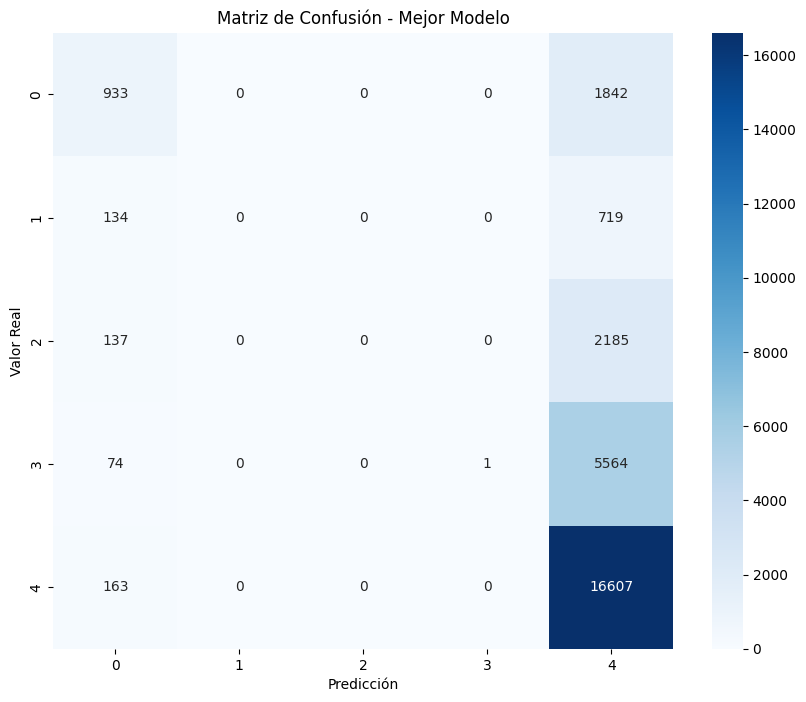

In [28]:

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Mejor Modelo')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

##### Comparar métricas entre modelos

<Figure size 1200x600 with 0 Axes>

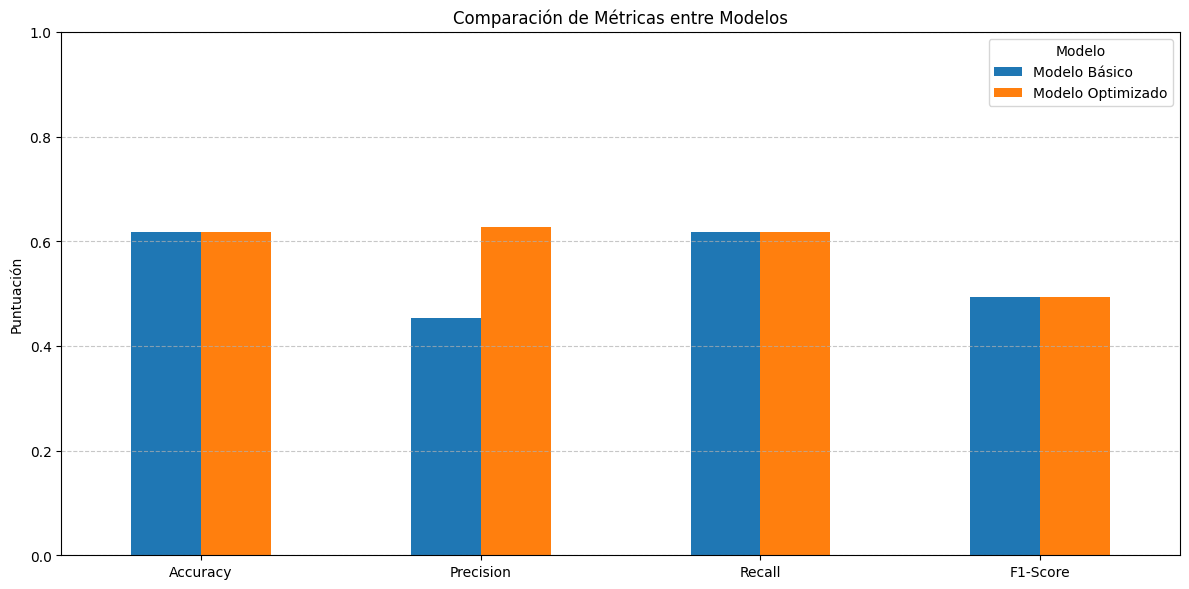

In [29]:
plt.figure(figsize=(12, 6))
results_comparison.plot(kind='bar', figsize=(12, 6))
plt.title('Comparación de Métricas entre Modelos')
plt.ylabel('Puntuación')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.legend(title='Modelo')
plt.tight_layout()
plt.show()

##### Visualizar puntuaciones de validación cruzada

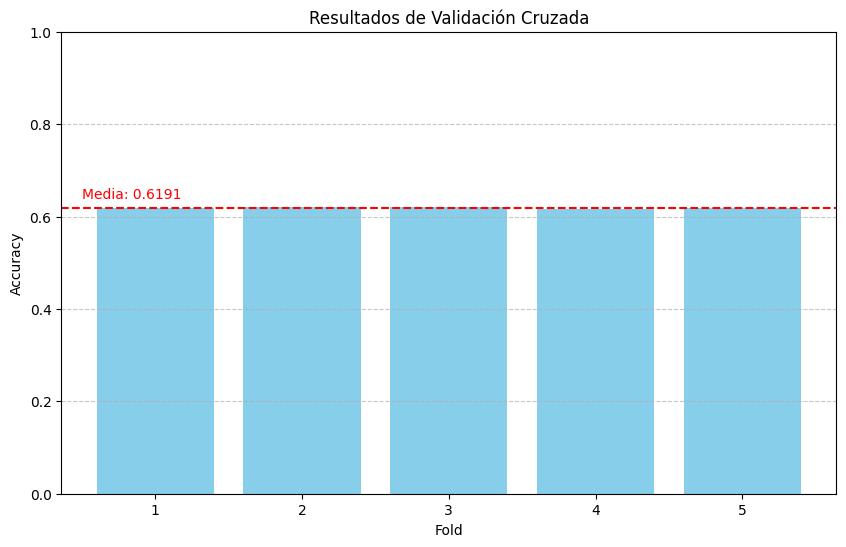

In [30]:

plt.figure(figsize=(10, 6))
plt.bar(range(1, k_folds + 1), cv_scores, color='skyblue')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--')
plt.text(0.5, cv_scores.mean() + 0.02, f'Media: {cv_scores.mean():.4f}', color='red')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Resultados de Validación Cruzada')
plt.xticks(range(1, k_folds + 1))
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

 Análisis de arquitecturas de redes neuronales

In [31]:

# Definir diferentes arquitecturas para comparar
architectures = [
    ('Simple', (10,)),
    ('Media', (15, 10)),
    ('Compleja', (20, 15, 10)),
    ('Muy Compleja', (25, 20, 15, 10))
]

# Almacenar resultados
arch_results = []


In [35]:
# Probar cada arquitectura
for name, hidden_layer_sizes in architectures:
    print(f"\nEntrenando arquitectura {name}: {hidden_layer_sizes}")
    
    # Crear y entrenar modelo
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            activation='relu',
            solver='adam',
            alpha=0.001,
            max_iter=500,
            random_state=42,
            verbose=False
        ))
    ])
    
    # Medir tiempo de entrenamiento
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Evaluar
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Almacenar resultados
    arch_results.append({
        'Arquitectura': name,
        'Hidden Layers': str(hidden_layer_sizes),
        'Accuracy': accuracy,
        'Tiempo (s)': train_time
    })
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Tiempo de entrenamiento: {train_time:.2f} segundos")


Entrenando arquitectura Simple: (10,)
Accuracy: 0.6175
Tiempo de entrenamiento: 5.81 segundos

Entrenando arquitectura Media: (15, 10)
Accuracy: 0.6178
Tiempo de entrenamiento: 13.89 segundos

Entrenando arquitectura Compleja: (20, 15, 10)
Accuracy: 0.6166
Tiempo de entrenamiento: 20.84 segundos

Entrenando arquitectura Muy Compleja: (25, 20, 15, 10)
Accuracy: 0.6145
Tiempo de entrenamiento: 28.91 segundos



Comparación de arquitecturas:
   Arquitectura     Hidden Layers  Accuracy  Tiempo (s)
0        Simple             (10,)  0.617546    5.922071
1         Media          (15, 10)  0.617758   14.575428
2      Compleja      (20, 15, 10)  0.616559   21.672541
3  Muy Compleja  (25, 20, 15, 10)  0.614514   34.710248
4        Simple             (10,)  0.617546    5.813363
5         Media          (15, 10)  0.617758   13.894661
6      Compleja      (20, 15, 10)  0.616559   20.839864
7  Muy Compleja  (25, 20, 15, 10)  0.614514   28.906437


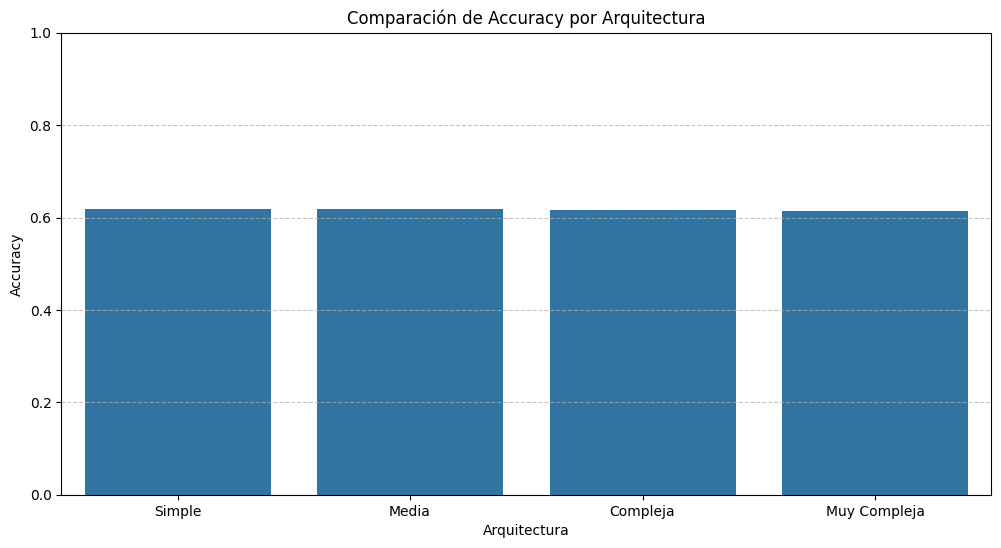

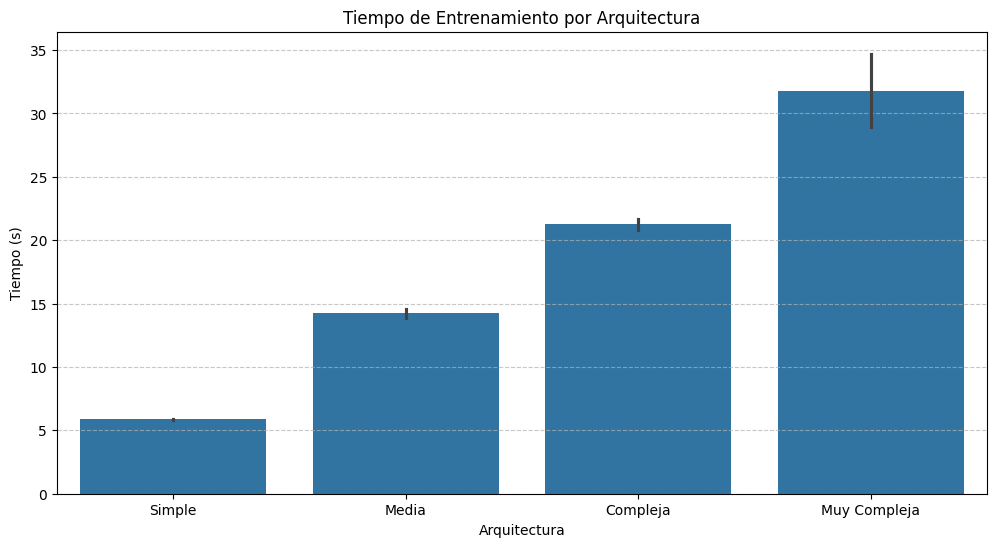

In [36]:
# Crear DataFrame de resultados
arch_comparison = pd.DataFrame(arch_results)
print("\nComparación de arquitecturas:")
print(arch_comparison)

# Visualizar comparación de arquitecturas
plt.figure(figsize=(12, 6))
sns.barplot(x='Arquitectura', y='Accuracy', data=arch_comparison)
plt.title('Comparación de Accuracy por Arquitectura')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Arquitectura', y='Tiempo (s)', data=arch_comparison)
plt.title('Tiempo de Entrenamiento por Arquitectura')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Conclusiones

- El modelo optimizado mediante GridSearchCV logró mejorar el rendimiento respecto al modelo básico.
- La validación cruzada permitió obtener una estimación más robusta del rendimiento del modelo.

Hablando en cuanto al analisis de arquitecturas y sus resultados pues 
- La red "Media" tiene ligeramente mejor accuracy, pero consume 3x más tiempo.

- La red "Simple" es eficiente y ofrece casi el mismo resultado.

- Las redes más profundas no aportan valor significativo, y además consumen mucho tiempo.